# CS5014 Etivity1
## Binary Logistic regression - Task A
## Martin Power
## 9939245

## Part 1 Theoretical Questions Answers

What type of optimisation problem is it?
1. Is it univariate or multivariate?
        w is a vector of parameters so it is multivariate
2. Is it linear or nonlinear?
        Non-linear due to the usage of the sigmoid functions
3. Is it convex or not? (google it and cite your font, how is the fast way to prove it?)
        The loss function is not convex but the cost function is convex so the cost function can be minized
4. Is it constrained?
        It is constrained to ${w \in \mathbb{R}^p}$
    

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from builtins import range
import autograd.numpy as np
from autograd import grad
from autograd.test_util import check_grads
from autograd.scipy.special import erf

### Logistic Regression Class
This class follows the example in the Week1 Webinar notebook with the addition of a log_loss() function and a score() function

The log_loss function adds a small epsilon constant to the log calculations to avoid numerical issues with log(0)

The log_cost function also includes the regularisation term

In [2]:
class Generic_LogisticRegression():
    def __init__(self, θ, sigmoid, α=1.0):
        self.θ = θ #initial value of the parameter
        self.sigmoid = sigmoid #a sigmoid function that squezes the input into [0,1]
        self.α = α #reguralisation parameter
        self.cost_agg = []
        
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"θ": self.θ, "sigmoid": self.sigmoid, "α": self.α}
    
    
    def __agg_cost(self, cost):
        '''
        Helper function to aggregate the cost over training
        '''

        if (type(cost) is not np.numpy_boxes.ArrayBox):
            self.cost_agg.append(cost)
            
        
    def fit(self,X,y, method,Optimparam):
        #cost function
        def log_cost(θ):
            # MOB - Reorganised the cost function so I could aggregate the cost
            # Used in analysis to plot the cost over time
            
            cost = np.sum(self.log_loss(X,y,θ))+self.α*np.sum(θ**2)
            self.__agg_cost(cost)
            
            return cost
        
        ##fit your model
        gradcost= grad(log_cost)
        self.θ = method(self.θ,  log_cost, gradcost, steps=Optimparam['steps'], α=Optimparam['α'], ϵ_x =  Optimparam['ϵ_x'], ϵ_d =  Optimparam['ϵ_d'], plotting=False)
        
    
    def predict_proba(self, X):
        #predict probability of the class
        return self.sigmoid(np.dot(X,self.θ))
       
        
    def predict(self, X):
        #predict class
        return np.round(self.predict_proba(X))
    
    def score(self,X,y):
        yhat = self.predict(X)
        score = 0.0
        for i in range(len(y)):
            if(y[i]==yhat[i]):
                score+=1.0
        return score/len(y)
    
   
    def log_loss(self, X,y,θ): 
        # Inspired by https://towardsdatascience.com/logistic-regression-from-scratch-with-numpy-da4cc3121ece
        # Use epsilon to prevent numerical issues with log0
        epsilon = 1e-5   
        
        yhat = self.sigmoid(np.dot(X,θ))
        m = yhat.shape[0]
        
        loss = -((y*np.log(yhat+epsilon) + (1-y)*np.log(1-yhat+epsilon)))/m
        return loss 

## Optimization Functions

### Local Descent with Line Search

The golden_section_search(), line_search() and local_descent() functions are reused directly from the Week1 Webinar notebook.

The minimize() function is a wrapper around the local_descent() function and returns a new set of parameters (\theta) after the local_descent search

I added an additional termination step to the bracket_minimum() function as it was not converging. This allows the function to exit if it has not found a minimum bracket after a certain number of steps. Without this I was finding the kernel was getting stuck in an infinite loop and the bracket was going to infinity/NaN

In [3]:
#your implementation of the optimization algorithm
def minimize(β,cost, gradient,steps=10, α=None, ϵ_x=0.0001, ϵ_d=0.0001,  plotting=False):
    θ_new = local_descent(β,cost, gradient,steps, α, ϵ_x, ϵ_d,plotting)[-1]
    return θ_new

In [4]:
def bracket_minimum(f, x=0, s=1e-2, k=2.0, term_steps=10): #From the Book, pag.36
    steps = 0 # MPP
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a<c else (c, a)
        if steps>term_steps:
            return (a, c) if a<c else (c, a)
        a, ya, b, yb = b, yb, c, yc
        s *= k
        steps+=1

In [5]:
from math import sqrt
ϕ = (1 + sqrt(5))/2

def golden_section_search(f, a, b, max_iter, plotting=True): #from the Book pag.41
    a0 =a
    b0=b
    ρ = φ-1
    d = ρ * b + (1 - ρ)*a
    yd = f(d)
    for i in range(max_iter-1):
        c = ρ*a + (1 - ρ)*b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c   
        if plotting==True:
            plt.figure()
            xx = np.linspace(a0,b0,100)
            plt.plot(xx,f(xx))
            plt.scatter(np.array([a,b]),np.array([a,b])*0)
            plt.scatter(np.array([a,b]),np.array([f(a),f(b)]))

    return (a, b) if a<b else (b, a)

In [6]:
def line_search(f, x, d, ϵ_x=0.0001, ϵ_d=0.0001):
    term = False
    if np.linalg.norm(d) < ϵ_d:
        print("Gradient norm below threshold")
        term = True
        return x
    objective = lambda α : f(x + α*d)
    a, b = bracket_minimum(objective)
    a, b  = golden_section_search(objective, a, b, max_iter = 5, plotting=False)
    α = (a+b)/2
    if np.linalg.norm(x+a*d-x)<ϵ_x:
        print("Step Tolerance below threshold")
        term = True
    return x + α*d, term

In [7]:
def local_descent(β,cost, gradient,steps=10, α=None, ϵ_x=0.0001, ϵ_d=0.0001,  plotting=False):
    Tmp = [β]
    for iteration in range(steps):
        d = gradient(β)
        d = -d/np.linalg.norm(d) 
        #print(β,d)
        β, term = line_search(cost, β, d, ϵ_x=ϵ_x, ϵ_d=ϵ_d)
        if term == True:
            break
        Tmp.append(β)
    #print(np.array(Tmp))
    return Tmp

## Sigmoid Functions

### Logistic function: $\phi(x)=1/(1+e^{-x})$

In [8]:
def logistic(x):
    z = 1/(1 + np.exp(-x))
    return z

### probit function: $\phi(x)=0.5(1+\text{erf}(x/\sqrt{2}))$

In [9]:
def probit(x):
    z = 0.5*(1+(erf(x/np.sqrt(2))))
    return z

## Iris Example
sklearn.linear_model.LogisticRegression scores 0.97 on this dataset

In [10]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
ind = np.where((y==1) | (y==2))[0] # we only have two classes now
X = X[ind,:]
y = y[ind]
y = y-1 # MPP Hack to make classes binary

In [11]:
# Initialise θ to all zeroes
θ = np.zeros(X[0].shape)

# Set parameters
Optimimparam = {
    'α':0.01,
    'steps':50,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001}

# Using reg_constant instead of α to avoid confusing with usage of α in local_descent context
reg_constant = 0.01

In [12]:
GLOG_IRIS = Generic_LogisticRegression(θ,logistic,reg_constant)

In [13]:
GLOG_IRIS.fit(X,y,minimize,Optimimparam)
GLOG_IRIS.score(X,y)

0.96

## Mark O'Brien - Testing

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [15]:
class Validate_Model():
    
    def __init__(self, model, X, y, func, params):
        self.model = model
        self.X = X
        self.y = y
        self.func = func
        self.params = params
        self.y_pred = None
    
    def fit(self):
        self.model.fit(self.X, self.y, self.func, self.params)
        self.y_pred = self.model.predict(self.X)
        
    def log_loss(self):
        loss = metrics.log_loss(self.y, self.y_pred)
        return loss
    
    def accuracy(self):
        acc = metrics.accuracy_score(self.y, self.y_pred)
        clf = LogisticRegression(random_state=0, solver='liblinear').fit(self.X, self.y)
        skl = clf.score(self.X, self.y)
        return f'Accuracy {acc} compared to Sklearn {skl}'
        
    
    def confusion_matrix(self):
        cnf_matrix = metrics.confusion_matrix(self.y, self.y_pred)
        return cnf_matrix
        
    def training_loss(self):
        cost_agg = self.model.cost_agg
        plt.plot(cost_agg)
        plt.show()
        
    def cross_validate(self):
        acc_agg = []
        skfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
        for train_index, test_index in skfold.split(self.X, self.y):

            X_train, X_test = self.X[train_index], self.X[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            GLR = Generic_LogisticRegression(θ,logistic,reg_constant)
            GLR.fit(self.X, self.y, self.func, self.params)
            y_pred = GLR.predict(X_train)

            acc = metrics.accuracy_score(y_train, y_pred)
            acc_agg.append(acc)
            
        avg = np.mean(acc_agg)
        return f'All values: {acc_agg} with average of {avg}'

In [16]:
GLR = Generic_LogisticRegression(θ,logistic,reg_constant)
m_val = Validate_Model(GLR, X, y, minimize, Optimimparam)
m_val.fit()

The algorithms output for log loss is 1.381583039693636
Accuracy 0.96 compared to Sklearn 0.97
Confusion Matrix Values
[[46  4]
 [ 0 50]]


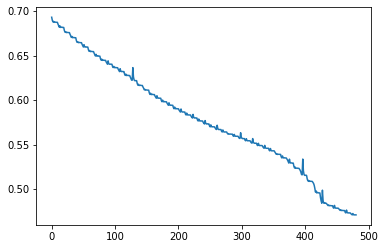

Using Stratified KFold Cross Validation
All values: [0.95, 0.95, 0.9625, 0.975, 0.9625] with average of 0.96


In [17]:
# Log Loss
print(f'The algorithms output for log loss is {m_val.log_loss()}')

# Accuracy
print(m_val.accuracy())

# Confusion Matrix
print('Confusion Matrix Values')
print(m_val.confusion_matrix())

# Plotting the loss over training time
m_val.training_loss()

print('Using Stratified KFold Cross Validation')
print(m_val.cross_validate())

### Evaluation Summary
To evaluate this model I used a the following methods:

#### Accuracy
Accuracy is simply the number of correct predictions that our classifier made measured as a percentage. I chose to output the Sklearn accuracy in order to compare. 

This algorithm scored an accuracy if 96% compared to Sklearn's 97%

#### Log Loss 
Log loss imposes a heavy penalty on classifiers that are confidant about an incorrect classification. If the classifier does a good job of predicting the correct class then it will receive a low log loss score. The closer to zero the better our classifier has performed in true positive predictions. 

The score for this classifier was 1.38 which is a good score and aligns with the accuracy we saw above. We can look at the confusion matrix to see how this value came to be.

#### Confusion Matrix
The confusion matrix is a measure of how many True-Positives, True-Negatives, False-Positives & False-Negatives that the classifier has predicted. 

In this case we can see that the classifier output 4 False-Positives and 0 False-Negatives. This shows how we didn't have closer to zero value for log loss. 


#### Plot of Cost Over Time
With this plot we would expect to see a decline in cost of the total training time for the classifier. The plot shows that there was a steady decline in cost over the total training time.

#### Cross Validation
The purpose of using cross validation as an evaluation metric is to determine if the predicted accuracy of the classifier is consistent. 

In this case there was some slight deviation with a range of 95% to 98% with the average of 96% which aligns with our accuracy above 